In [ ]:
import numpy as np
from os import path as osp
import glob
import cv2
import matplotlib.pyplot as plt

from retrievalnet.settings import DATA_PATH
from utils import plot_imgs
from retrievalnet.datasets.utils.nclt_undistort import Undistort
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [133]:
seq = '2012-01-08'
#seq = '2013-04-05'
cam = 'Cam4'

In [134]:
root = DATA_PATH+'datasets/nclt/'
gt_file = root+'groundtruth_{}.csv'.format(seq)
im_root = root+'{}/lb3/{}/'.format(seq, cam)
dumap_file = root+'undistort_maps/U2D_{}_1616X1232.txt'.format(cam)

In [135]:
gt = np.loadtxt(open(gt_file, "rb"), delimiter=",", skiprows=1)
im_list = glob.glob(osp.join(im_root, '*.tiff'))
im_list = [osp.splitext(osp.split(i)[1])[0] for i in im_list]
im_list = sorted(im_list, key=lambda i: int(i))
im_list = im_list[5:] # drop 5 first frames
d2u = Undistort(dumap_file)

In [136]:
# Remove distortion mask
h, w = d2u.mask.shape
x_min, x_max = [f(np.where(d2u.mask[int(h/2), :])[0]) for f in [np.min, np.max]]
y_min, y_max = [f(np.where(d2u.mask[:, int(w/2)])[0]) for f in [np.min, np.max]]
def imread(name, undis=True):
    im = cv2.imread(im_root+name+'.tiff')
    if undis:
        im = d2u.undistort(im)[y_min:y_max, x_min:x_max, ...]
    return np.rot90(im, k=3)

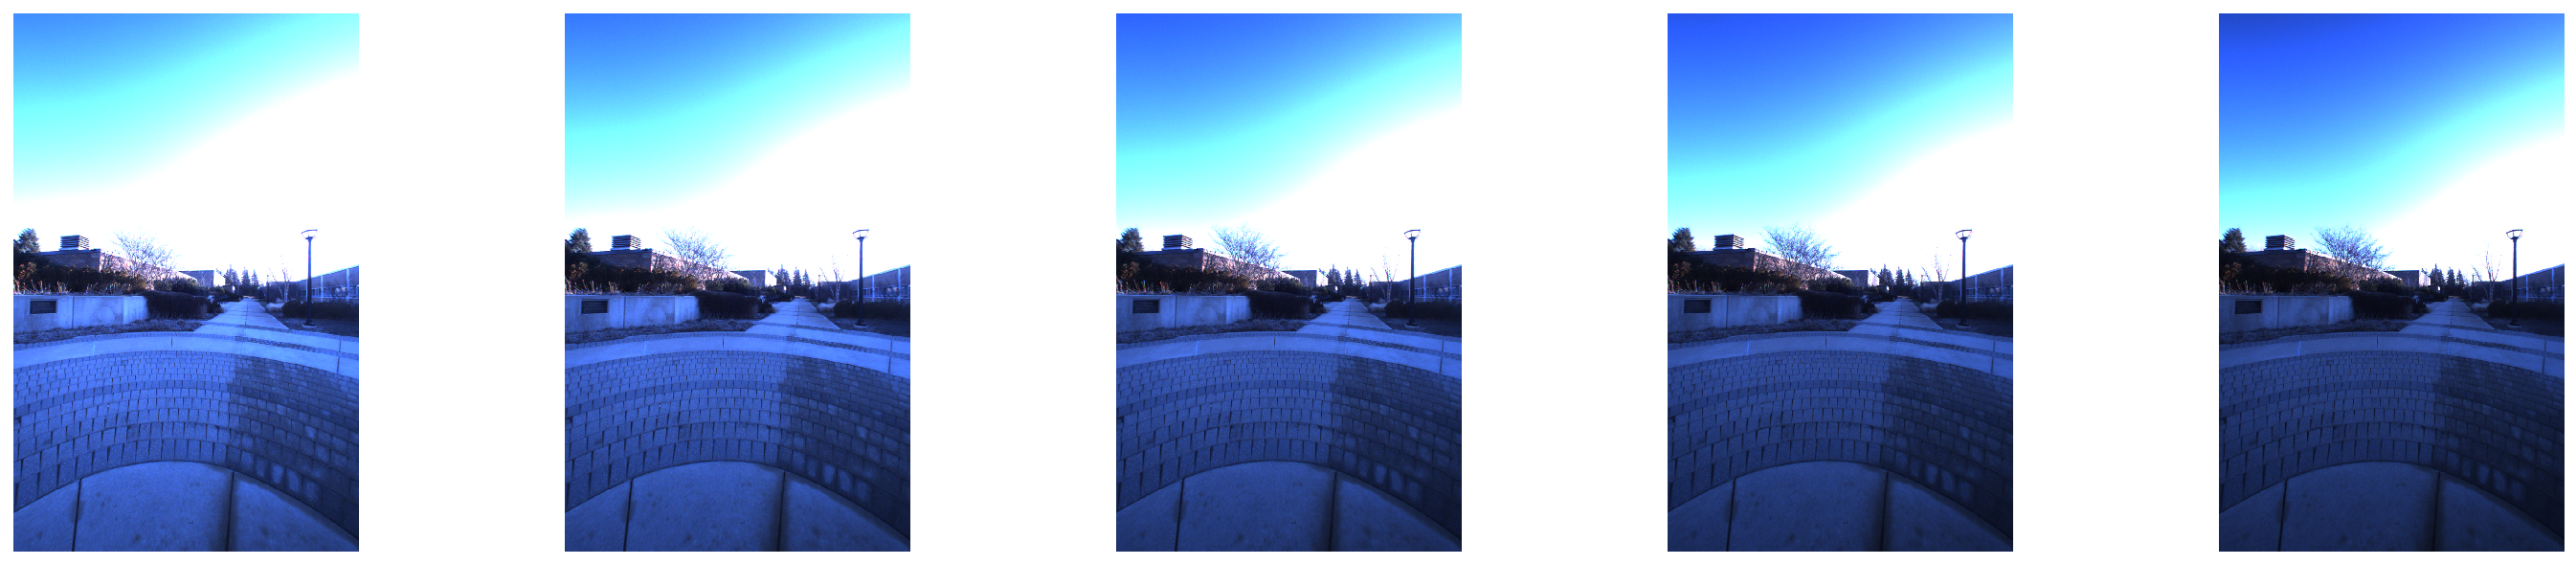

In [137]:
plot_imgs([imread(im_list[i]) for i in range(5)])

In [138]:
def find_nearest(array, value):
    return (np.abs(array-value)).argmin()

In [139]:
n_keep = 1000
distance = np.cumsum(np.linalg.norm(gt[1:,1:3] - gt[:-1,1:3], axis=1))
keypoints = np.linspace(0, np.max(distance), num=n_keep)
gt_idx = [find_nearest(distance, k) for k in keypoints]
im_idx = [find_nearest([int(im) for im in im_list], gt[i,0]) for i in gt_idx]
print('Distance between keypoints: {}'.format(np.max(distance)/n_keep))

Distance between keypoints: 6.498091880006353


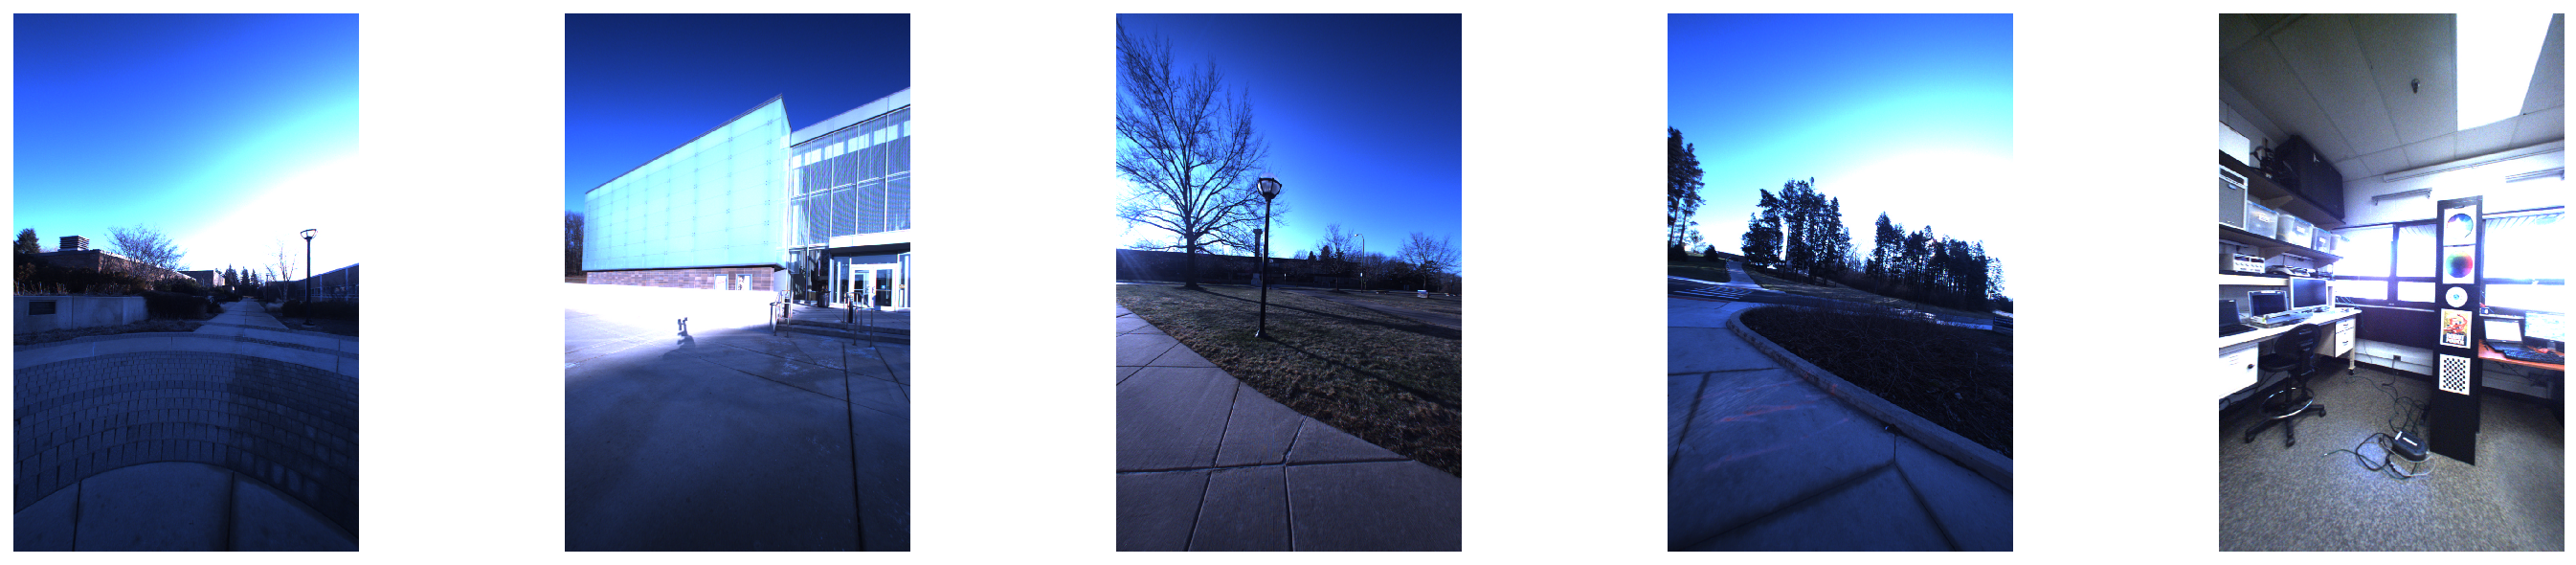

In [140]:
plot_imgs([imread(im_list[im_idx[i]]) for i in np.linspace(0, n_keep-1, num=5, dtype=np.int)])

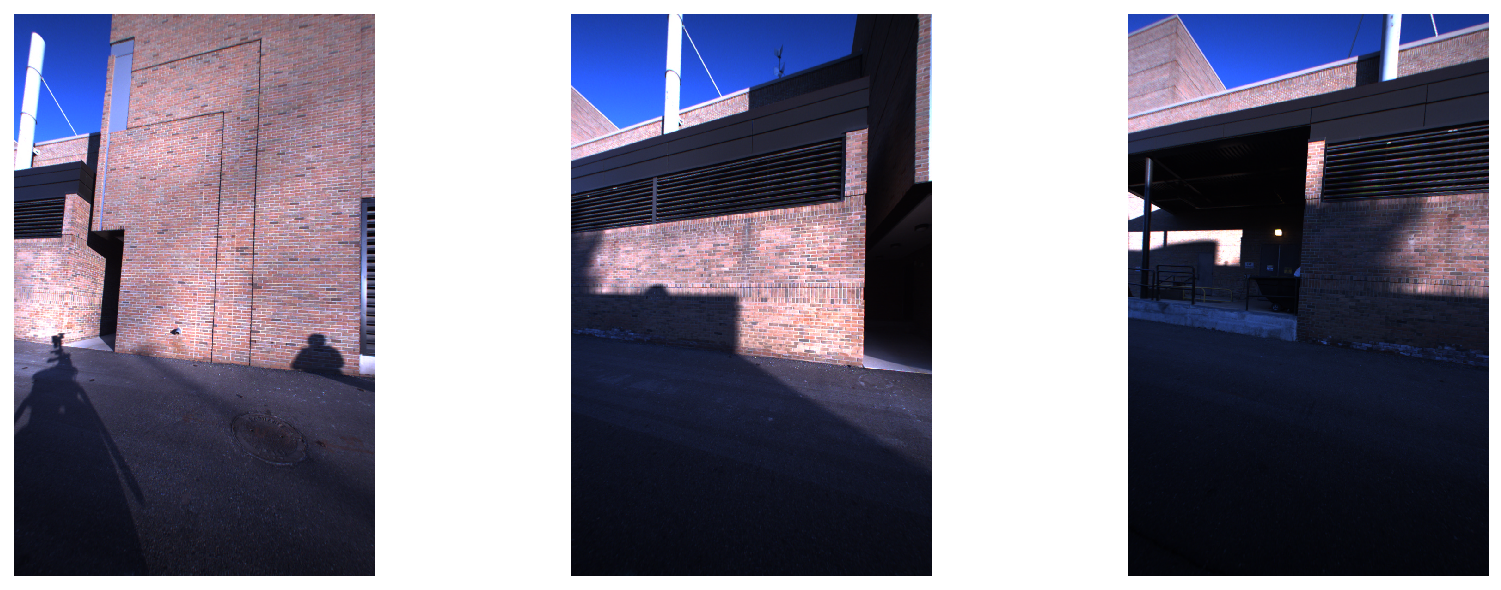

In [141]:
plot_imgs([imread(im_list[im_idx[i]]) for i in [100, 101, 102]])

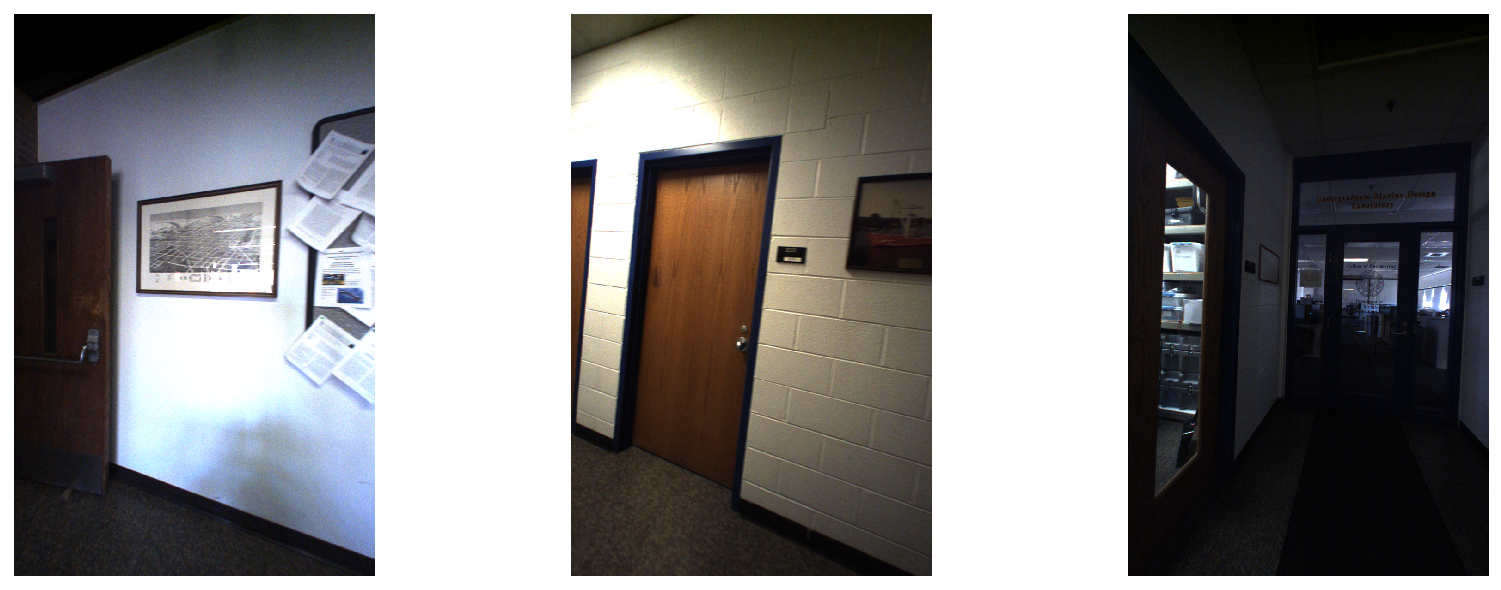

In [142]:
plot_imgs([imread(im_list[im_idx[i]]) for i in [996, 997, 998]])

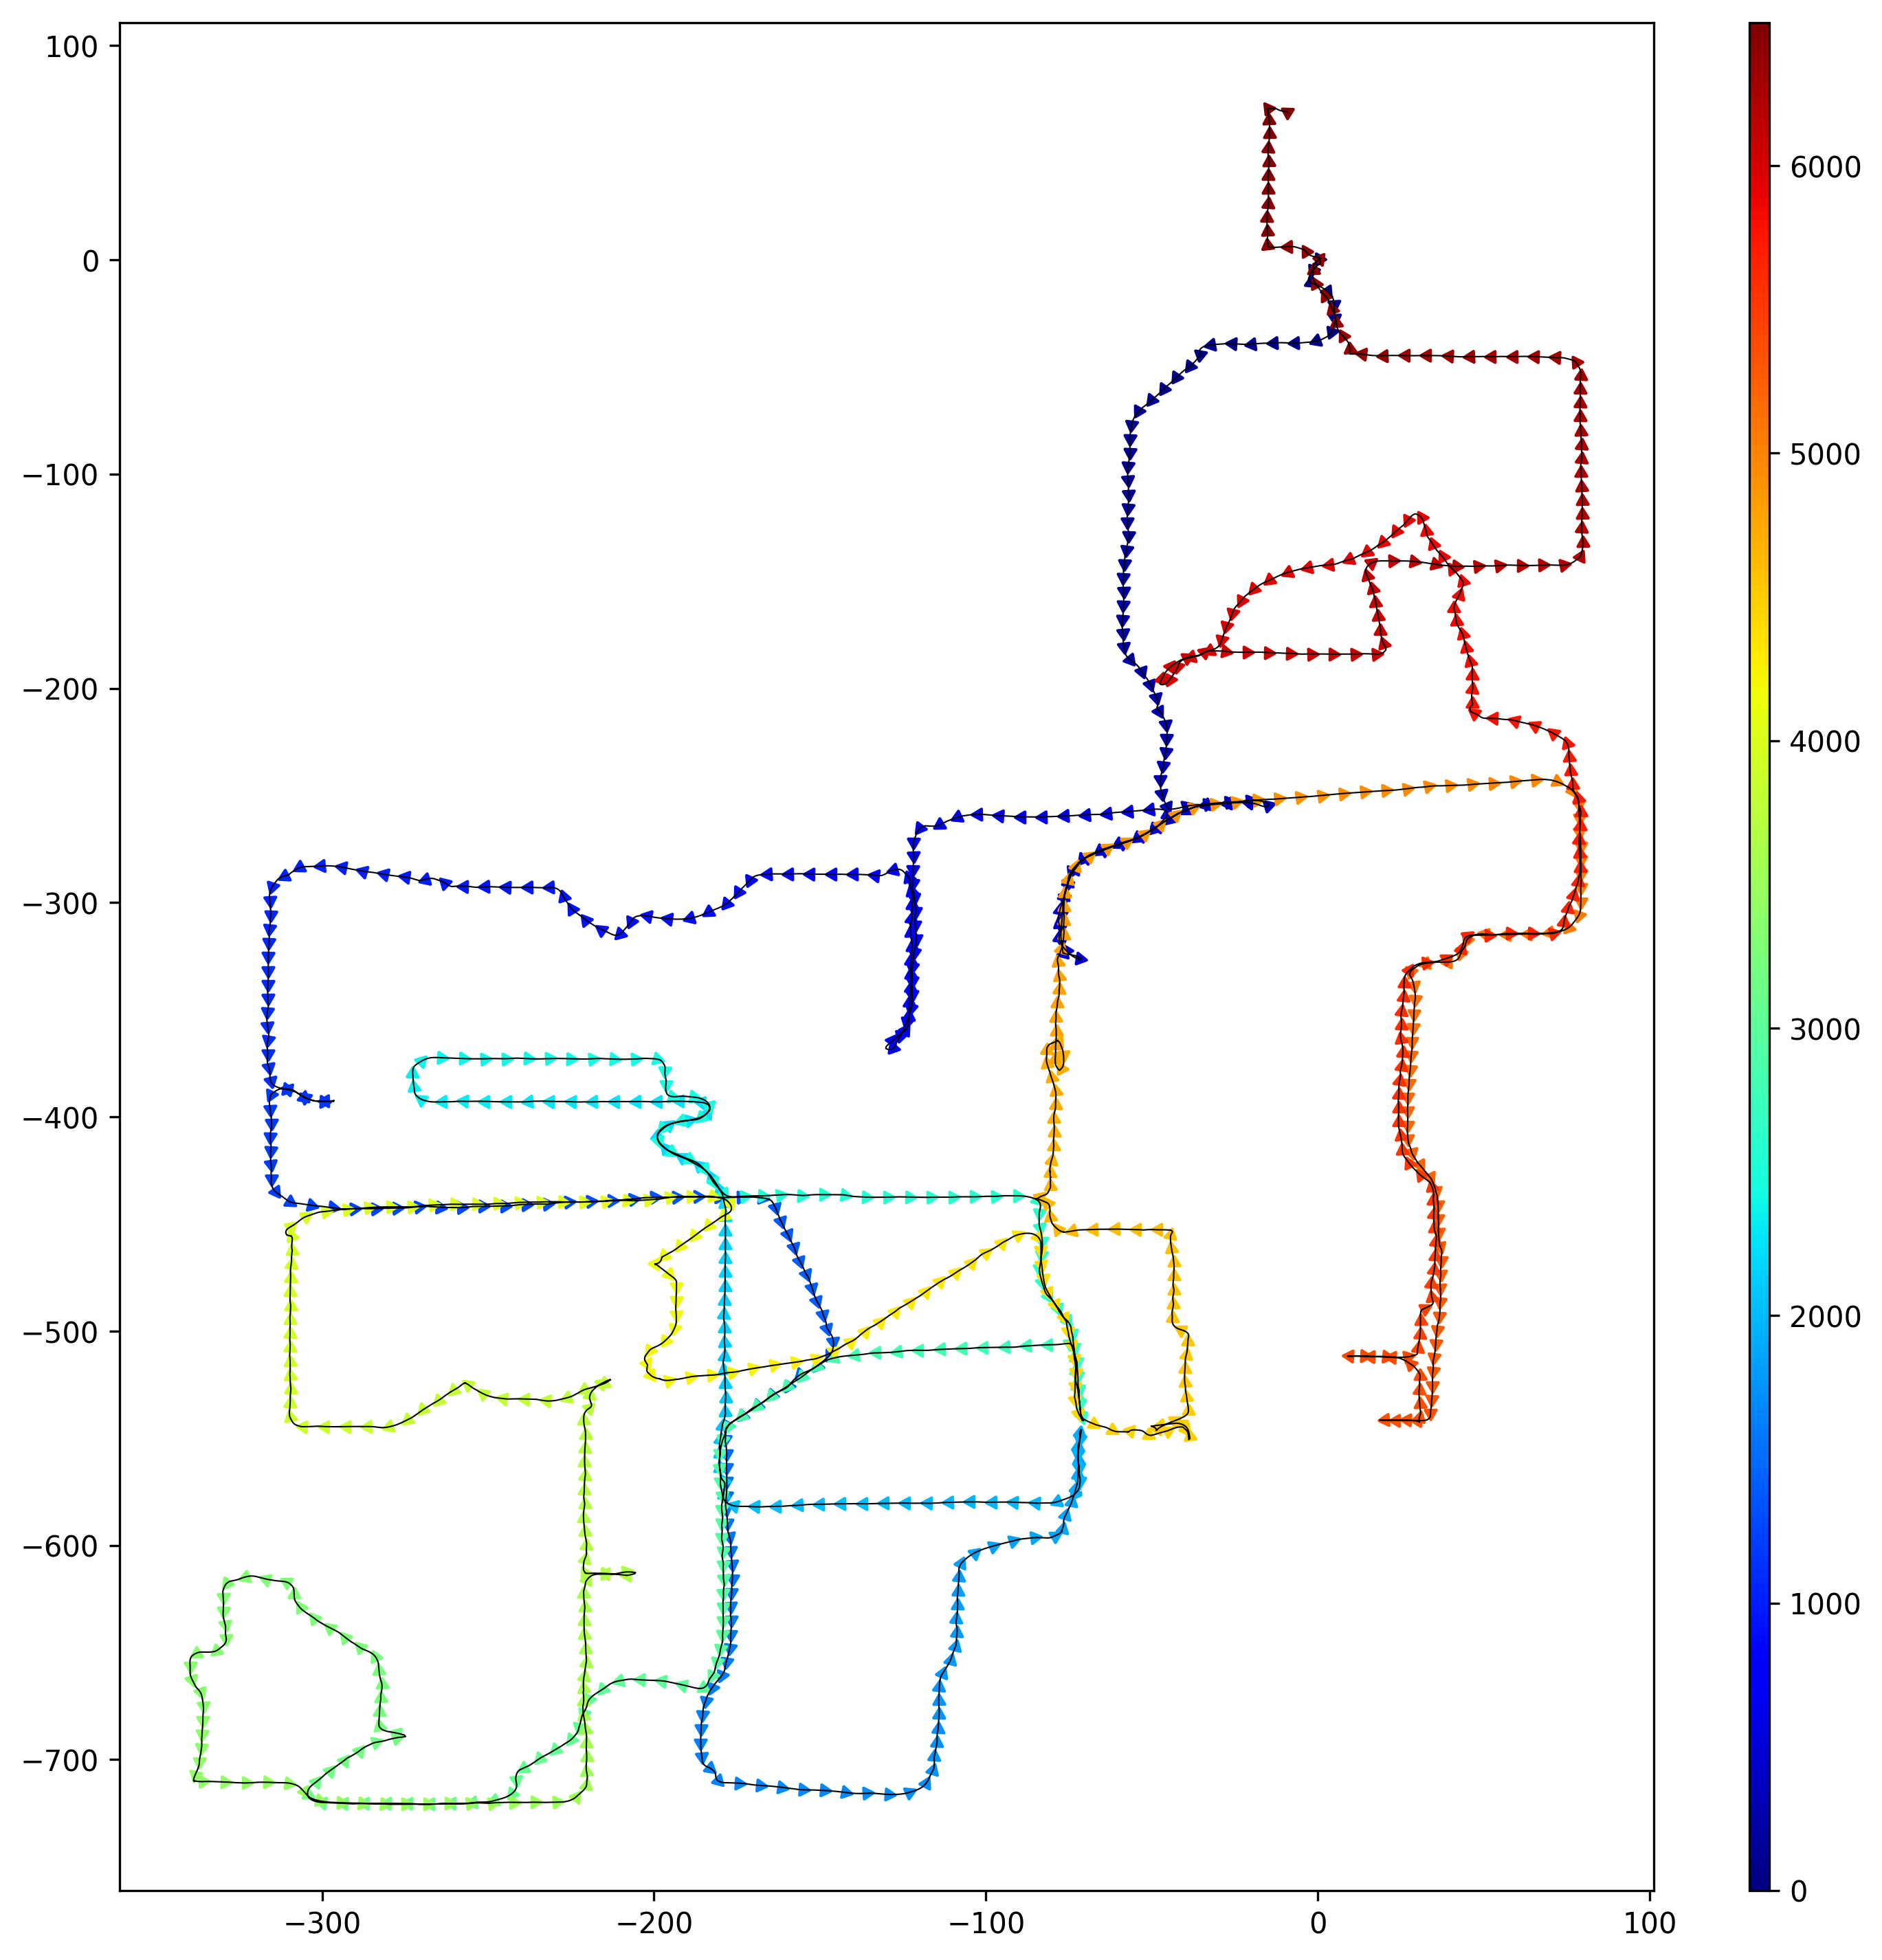

In [175]:
plt.figure(figsize=(12, 12), dpi=300)
plt.plot(gt[:,1], gt[:,2], linewidth=0.5, color='k');
#plt.scatter(gt[gt_idx,1], gt[gt_idx,2], linestyle = 'None', marker='o', c=keypoints, cmap='jet', alpha=0.5);
for i, idx in enumerate(gt_idx):
    plt.scatter(gt[idx,1], gt[idx,2], linestyle = 'None', c=[keypoints[i]], cmap='jet', s=20,
                marker=(3, 1, 180*gt[idx,6]/np.pi-90), alpha=1, norm=plt.Normalize(vmin=0, vmax=np.max(keypoints)));
plt.colorbar(use_gridspec=True, aspect=95);

In [144]:
np.savetxt(root+'pose_{}.csv'.format(seq),
           np.rec.fromarrays((np.array(im_list, dtype=np.int)[im_idx], gt[gt_idx, 1], gt[gt_idx, ])),
           delimiter=',',
           fmt='%i, %.15f, %.15f',
           header='time, pose_x, pose_y')